# **Qutrit-based QAE using the Majorana encoding** (Our paper code)

This script implements a **full workflow for a qutrit-based Quantum Autoencoder (QAE) applied to jet event data**. It begins by **loading and preprocessing jet data** from JSON files, extracting kinematic properties and selecting top constituents, while also including extended features like traversal (`d0`) and longitudinal (`dz`) impact parameters. The processed dataset is then **split into training, validation, and inference subsets** with reproducible randomization.

The script defines the **mathematical framework for qutrit operations**, including Gell-Mann matrices (SU(3)), Spin-1 rotation generators (SO(3) ⊂ SU(3)), TSWAP gates, unitary construction from generators, and qutrit state initialization. These tools enable encoding, manipulation, and variational optimization of qutrit quantum states in a quantum circuit using the majorana encoding.

The **QAE circuit** combines an encoder that prepares initial qutrit states from jet constituent features, a parameterized variational layer with TAdd and single-qutrit rotations, and controlled TSWAP operations between trash and reference qutrits using an ancilla. The **cost function** is defined as the negative fidelity of the ancilla, guiding gradient-based optimization.

During **training**, variational parameters are updated via the Adam optimizer across the training dataset, with per-event and average fidelities tracked to monitor performance. After training, the QAE is applied to **inference datasets** (background and signal jets), computing per-event fidelities and assigning binary labels for analysis.

Finally, the script provides **visualizations**: histograms of quantum fidelities across datasets to compare reconstruction performance, and **ROC curves with AUC calculations** to evaluate the QAE's anomaly detection capability. Overall, it offers a complete pipeline for preprocessing, qutrit-based encoding, variational training, inference, and performance evaluation of a quantum autoencoder for high-energy physics jet data.


In [ ]:
import ijson
import numpy as np
import json
from decimal import Decimal
import json
import time
import torch
import warnings
import numpy as np
from IPython.display import clear_output
import pennylane as qml
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# **Loading and processing jet event data with extended features**

This code defines a function `cargar_datos_json` to **load and preprocess jet event data** from JSON files. For each jet, it calculates kinematic properties (`pt`, `eta`, `phi`, `mass`, `energy`) and selects the top constituents based on transverse momentum (`pt`). For each constituent, it also extracts additional features such as traversal (`d0`) and longitudinal (`dz`) impact parameters. The processed jets from multiple JSON files are then combined into a single dataset for further analysis or quantum encoding.


### **Real CMS data**

In [ ]:
datos = []

def cargar_datos_json(json_path, num_jets=22500, num_constituents=10):
    with open(json_path, 'r') as f:
        data = json.load(f)

    eventos = []
    for i, evento in enumerate(data[:num_jets]):
        jet_pt, jet_eta, jet_phi, jet_mass = evento['jet_kinematics']
        constituents = evento['PFCands']
        theta = 2 * np.arctan(np.exp(-jet_eta))
        p = jet_pt / np.sin(theta)
        pz  = p * np.cos(theta)
        jet_energy = np.sqrt(pz**2 + jet_pt**2 + jet_mass**2)
        

        # Calculate pT for each constituent
        constituents = np.array(constituents)
        px = constituents[:, 0]
        py = constituents[:, 1]
        pt = np.sqrt(px**2 + py**2)

        # Indexes of the top num_constituents by pT
        indices_ordenados = np.argsort(pt)[::-1][:num_constituents]
        top_cands = constituents[indices_ordenados]

        # Convert each to the format used in the circuit
        top_constituents = []
        for cand in top_cands:
            px, py, pz, E = cand[0:4]
            d0 = cand[4]  # traversal impact parameter
            dz = cand[5]  # longitudinal impact parameter
            pt = np.sqrt(px**2 + py**2)
            p_total = np.sqrt(px**2 + py**2 + pz**2)
            eta = 0.5 * np.log((p_total + pz) / (p_total - pz + 1e-8))  # Avoiding dividing by 0
            phi = np.arctan2(py, px)
            mass = np.sqrt(np.maximum(0, E**2 - (px**2 + py**2 + pz**2)))# In case of negative mass, set it to zero
            top_constituents.append({
                'pt': pt,
                'eta': eta,
                'phi': phi,
                'mass': mass,
                'energy': E,
                'd0': d0,
                'dz': dz
            })

        eventos.append({
            'pt_jet': jet_pt,
            'eta_jet': jet_eta,
            'phi_jet': jet_phi,
            'mass_jet': jet_mass,
            'energy_jet': jet_energy,
            'constituents': top_constituents
        })

    return eventos


datos_00 = cargar_datos_json('/Volumes/usb_MCarou/runG_batch0_flatpt.json')
datos_01 = cargar_datos_json('/Volumes/usb_MCarou/runG_batch10_flatpt.json')
datos = datos_00 + datos_01

### **Simulated CMS data**

In [ ]:
import json
import numpy as np

def cargar_datos_json(json_path, num_jets=10000, num_constituents=10):
    with open(json_path, 'r') as f:
        data = json.load(f)

    eventos = []
    for i, evento in enumerate(data[:num_jets]):
        # Extract jet kinematics
        jet_pt = evento.get('jet_pt', i)
        jet_eta = evento.get('jet_eta', i)
        jet_phi = evento.get('jet_phi', i)
        jet_mass = evento.get('jet_sdmass', i)
        jet_energy = evento.get('jet_energy', i)
        jet_tau1 = evento.get('jet_tau1', i)
        jet_tau2 = evento.get('jet_tau2', i)
        jet_tau3 = evento.get('jet_tau3', i)    
        jet_tau4 = evento.get('jet_tau4', i)

        jet_tau12 = jet_tau1 / jet_tau2 if jet_tau2 != 0 else 0
        jet_tau23 = jet_tau2 / jet_tau3 if jet_tau3 != 0 else 0
        jet_tau34 = jet_tau3 / jet_tau4 if jet_tau4 != 0 else 0

        # Extract constituents (particles)
        part_px = np.array(evento.get('part_px', []))
        part_py = np.array(evento.get('part_py', []))
        part_pz = np.array(evento.get('part_pz', []))
        part_energy = np.array(evento.get('part_energy', []))
        part_d0val = np.array(evento.get('part_d0val', []))
        part_dzval = np.array(evento.get('part_dzval', []))
        
        # Calculate pT, eta, phi, mass for each constituent
        pt = np.sqrt(part_px**2 + part_py**2)
        p_total = np.sqrt(part_px**2 + part_py**2 + part_pz**2)
        eta = 0.5 * np.log((p_total + part_pz) / (p_total - part_pz + 1e-8))  # Avoiding dividing by 0
        phi = np.arctan2(part_py, part_px)
        mass = np.sqrt(np.maximum(0, part_energy**2 - (part_px**2 + part_py**2 + part_pz**2)))
        
        # Seleccionar los num_constituents con mayor pt
        indices_ordenados = np.argsort(pt)[::-1][:num_constituents]
        
        top_constituents = []
        for idx in indices_ordenados:
            top_constituents.append({
                'pt': pt[idx],
                'eta': eta[idx],
                'phi': phi[idx],
                'px': part_px[idx],
                'py': part_py[idx],
                'pz': part_pz[idx],
                'mass': mass[idx],
                'energy': part_energy[idx],
                'd0': part_d0val[idx],
                'dz': part_dzval[idx]
            })
            
        eventos.append({
            'pt_jet': jet_pt,
            'eta_jet': jet_eta,
            'phi_jet': jet_phi,
            'mass_jet': jet_mass,
            'energy_jet': jet_energy,
            'tau1_jet': jet_tau1,
            'tau2_jet': jet_tau2,
            'tau3_jet': jet_tau3,
            'tau4_jet': jet_tau4,
            'tau12_jet': jet_tau12,
            'tau23_jet': jet_tau23,
            'tau34_jet': jet_tau34,
            'constituents': top_constituents
        })

    return eventos

datos_HToBB = cargar_datos_json('/Volumes/usb_MCarou/HToBB_120_flat.json', num_jets=10000, num_constituents=10)
datos_TTBar = cargar_datos_json('/Volumes/usb_MCarou/TTBar_120_flat.json', num_jets=10000, num_constituents=10)
datos_WToqq = cargar_datos_json('/Volumes/usb_MCarou/WToQQ_120_flat.json', num_jets=10000, num_constituents=10)
datos_QCD_simu_1 = cargar_datos_json('/Volumes/usb_MCarou/ZJetsToNuNu_120_flat.json', num_jets=22500, num_constituents=10)
datos_QCD_simu_2 = cargar_datos_json('/Volumes/usb_MCarou/ZJetsToNuNu_120_flat.json', num_jets=22500, num_constituents=10)
datos_QCD_simu_full = datos_QCD_simu_1 + datos_QCD_simu_2

# **Splitting jet data into training, validation, and inference sets**

This code converts the processed jet data into a NumPy array and **splits it into training, validation, and inference subsets**. Specifically, it allocates 10,000 events for training, 2,500 for validation, and the remaining 10,000 for inference. The splits are randomized with a fixed seed for reproducibility, and the sizes of each subset are printed to verify the split.


In [ ]:
datos = np.array(datos)

# Splitting 10,000 for training and 12,500 remaining
X_train, X_temp = train_test_split(
    datos, 
    train_size=10000, 
    random_state=42, 
    shuffle=True
)

# Splitting 2,500 for validation and 10,000 for inference
X_val, X_inf = train_test_split(
    X_temp, 
    train_size=2500, 
    random_state=42, 
    shuffle=True
)


print(f"Trainning: {len(X_train)}")
print(f"Validation: {len(X_val)}")
print(f"Inference: {len(X_inf)}")

Entrenamiento: 10000
Validación: 2500
Inferencia: 10000


In [ ]:
datos = np.array(datos)
X_train, X_temp = train_test_split(
    datos, 
    train_size=10000, 
    random_state=42, 
    shuffle=True
)

X_val, rest = train_test_split(
    X_temp, 
    train_size=2500, 
    random_state=42, 
    shuffle=True
)

X_inf, rest = train_test_split(
    rest, 
    train_size=10000, 
    random_state=42, 
    shuffle=True
)

# Verificar tamaños
print(f"Entrenamiento: {len(X_train)}")
print(f"Validación: {len(X_val)}")
print(f"Inferencia: {len(X_inf)}")

### **Remider of the structure**

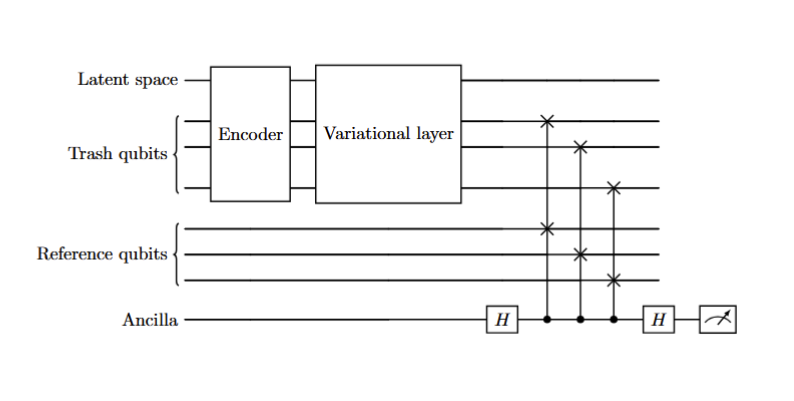

# **Qutrit quantum operators, rotation generators, and state initialization**

This code defines the **mathematical framework for qutrit quantum operations** using PennyLane, PyTorch, and NumPy. It includes:

- **Gell-Mann matrices (`Lambda`)** representing SU(3) algebra, including the identity.
- **Spin-1 rotation generators (`Sigma`)** for the SO(3) subalgebra of SU(3).
- **TSWAP operator (`TSWAP_matrix`)** for exchanging two qutrit states.
- **Unitary construction (`unitary_from_generator`)** from a rotation generator and angle.
- **Qutrit state initialization (`inicializing_qutrit_state`)**, creating a normalized qutrit vector from input angles.
- **Unitary from state (`unitary_from_state`)**, producing a 3×3 unitary matrix with the given qutrit state as its first column.

These components provide the foundational tools to encode, manipulate, and rotate qutrit quantum states for simulations or quantum circuits.


In [ ]:
# Gell-Mann matrices (SU(3))
Lambda = {
    1: torch.tensor([[0, 1, 0],
                 [1, 0, 0],
                 [0, 0, 0]], dtype=torch.cdouble),

    2: torch.tensor([[0, -1j, 0],
                 [1j, 0, 0],
                 [0, 0, 0]], dtype=torch.cdouble),

    3: torch.tensor([[1, 0, 0],
                 [0, -1, 0],
                 [0, 0, 0]], dtype=torch.cdouble),

    4: torch.tensor([[0, 0, 1],
                 [0, 0, 0],
                 [1, 0, 0]], dtype=torch.cdouble),

    5: torch.tensor([[0, 0, -1j],
                 [0, 0, 0],
                 [1j, 0, 0]], dtype=torch.cdouble),

    6: torch.tensor([[0, 0, 0],
                 [0, 0, 1],
                 [0, 1, 0]], dtype=torch.cdouble),

    7: torch.tensor([[0, 0, 0],
                 [0, 0, -1j],
                 [0, 1j, 0]], dtype=torch.cdouble),

    8: (1/torch.sqrt(torch.tensor(3.0))) * torch.tensor([[1, 0, 0],
                                  [0, 1, 0],
                                  [0, 0, -2]], dtype=torch.cdouble),
    0: torch.tensor([[1, 0, 0],
                 [0, 1, 0],
                 [0, 0, 1]], dtype=torch.cdouble)
}

# Spin-1 rotation generators (SO(3) ⊂ SU(3))
Sigma = {
    1: (1 / torch.sqrt(torch.tensor(2.0))) * torch.tensor([
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0]
    ], dtype=torch.cdouble),

    2: (1 / torch.sqrt(torch.tensor(2.0))) * torch.tensor([
        [0, -1j, 0],
        [1j, 0, -1j],
        [0, 1j, 0]
    ], dtype=torch.cdouble),

    3: torch.tensor([
        [1, 0, 0],
        [0, 0, 0],
        [0, 0, -1]
    ], dtype=torch.cdouble)
}

def TSWAP_matrix():
    tswap = np.zeros((9, 9), dtype=complex)
    for i in range(3):
        for j in range(3):
            ket = np.zeros(9)
            bra = np.zeros(9)
            ket[3*i + j] = 1   # |i⟩|j⟩
            bra[3*j + i] = 1   # |j⟩|i⟩
            tswap += np.outer(bra, ket)
    return tswap


def unitary_from_generator(generator_matrix, theta):
    if not torch.is_tensor(theta):
        theta = torch.tensor(theta, dtype=torch.cdouble)
    i = torch.tensor(1j, dtype=torch.cdouble)
    return Lambda[0] + (torch.cos(theta) - torch.tensor(1.0)) * generator_matrix @ generator_matrix + i * torch.sin(theta) * generator_matrix

def inicializing_qutrit_state(theta1, theta2, phi1, phi2):
    Gamma= 0
    a0 = 0
    a1 = 0
    a2 = 0

    Gamma = torch.sqrt(torch.tensor(2.0)) * (torch.tensor(3.0) + torch.cos(theta1)*torch.cos(theta2) + torch.sin(theta1)*torch.sin(theta2)*torch.cos(phi1 - phi2))**(torch.tensor(-0.5))

    a0 = (torch.sqrt(torch.tensor(2.0)) * torch.cos(theta1/2) * torch.cos(theta2/2)).item()
    a1 = (torch.exp(1j * phi1) * torch.sin(theta1/2) * torch.cos(theta2/2) + torch.cos(theta1/2) * torch.sin(theta2/2) * torch.exp(1j * phi2)).item()
    a2 = (torch.sqrt(torch.tensor(2.0)) * torch.exp(1j * (phi1 + phi2)) * torch.sin(theta1/2) * torch.sin(theta2/2)).item()

    state = Gamma * torch.tensor([a0, a1, a2], dtype=torch.cdouble)
    state = state / torch.linalg.norm(state)
    
    

    return state.detach().clone().numpy()

import numpy as np
from scipy.linalg import qr

def unitary_from_state(psi):
    """
    psi: complex normalized vector of dimension 3 (qutrit)
    returns: 3x3 unitary whose first column is psi
    """
    psi = psi / np.linalg.norm(psi)  # por seguridad
    
    a1 = torch.tensor([0.555,0, 0.555], dtype=torch.cdouble)
    a2 = torch.tensor([0.555,0.555, 0], dtype=torch.cdouble)
    mat = np.column_stack([psi, a1 , a2])

    Q, R = qr(mat)
    phase = np.vdot(psi, Q[:,0])
    Q[:,0] = Q[:,0] * (phase/abs(phase)).conj()
    
    return Q



# **Qutrit-based quantum autoencoder circuit with encoding and variational layer**

This code implements a **qutrit-based Quantum Autoencoder (QAE)** using PennyLane and PyTorch. Key components include:

- **Circuit Parameters:**  
  Defines number of particles, latent, reference, trash wires, and ancilla qutrit. Uses `"default.qutrit"` device.

- **Encoding Functions:**  
  Normalizes and maps jet constituent features (η, φ, mass, energy, d0, dz) to rotation angles for qutrit state preparation.

- **Encoder (`encode_1p1q_qutrit`)**:  
  Prepares initial qutrit states for each particle using constituent features, converts them to unitaries, and applies them to the circuit.

- **Variational Layer (`variational_layer_qutrit`)**:  
  Parameterized layer applying **TAdd gates** and single-qutrit rotations (RX, RY, RZ) for optimization.

- **QAE Circuit (`qae_circuit_qutrit`)**:  
  Combines encoding, variational layers, and controlled **TSWAP operations** between trash and reference wires using ancilla qutrit. Measures ancilla to compute probabilities.

- **Cost Function (`cost_function_with_fidelity_qutrit`)**:  
  Uses the ancilla probability to compute **negative fidelity** as the optimization cost.


In [ ]:
# Parameters
from autoray import do


num_particles = 4
num_latent = 1
num_ref = num_particles - num_latent
num_trash = num_ref
wires = list(range(num_particles + num_ref + 1))  # +1 ancilla
ancilla = wires[-1]
dev = qml.device("default.qutrit", wires=wires)  

latent_wire = 0
trash_wires = wires[1:num_particles]
ref_wires = wires[num_particles:-1]

# Encoding functions
def f(w): return 1 + (2 * np.pi / (1 + torch.exp(-w)))
def phi_circuit(w, phi, phi_jet, pt, pt_jet): return f(w) * (pt / pt_jet) * (phi - phi_jet)
def theta_circuit(w, eta, eta_jet, pt, pt_jet): return f(w) * (pt / pt_jet) * (eta - eta_jet)
def mass_circuit(w, mass, mass_jet, pt, pt_jet):  return  f(w) * (pt / pt_jet) * (mass - mass_jet)
def energy_circuit(w, energy, energy_jet, pt, pt_jet): return f(w) * (pt / pt_jet) *  (energy - energy_jet)
def d0_circuit(w, d0, pt, pt_jet): return f(w) * (pt / pt_jet) * (d0)
def dz_circuit(w, dz, pt, pt_jet): return f(w) * (pt / pt_jet) * (dz)
def tau12_circuit(w, tau12, pt, pt_jet): return f(w) * (pt / pt_jet) * (tau12)
def tau23_circuit(w, tau23, pt, pt_jet): return f(w) * (pt / pt_jet) * (tau23)
def tau34_circuit(w, tau34, pt, pt_jet): return f(w) * (pt / pt_jet) * (tau34)
def tau1_circuit(w, tau1, pt, pt_jet): return f(w) * (pt / pt_jet) * (tau1)
def tau2_circuit(w, tau2, pt, pt_jet): return f(w) * (pt / pt_jet) * (tau2)
def tau3_circuit(w, tau3, pt, pt_jet): return f(w) * (pt / pt_jet) * (tau3)
def tau4_circuit(w, tau4, pt, pt_jet): return f(w) * (pt / pt_jet) * (tau4)

# Encoding for qutrits
def encode_1p1q_qutrit(jets, w, unitaries):

    pt_jet = jets['pt_jet']
    eta_jet = jets['eta_jet']
    phi_jet = jets['phi_jet']
    mass_jet = jets['mass_jet']
    energy_jet = jets['energy_jet']
    #tau12_jet = jets['tau12_jet']
    #tau23_jet = jets['tau23_jet']
    #tau34_jet = jets['tau34_jet']
    constituents = jets['constituents']
        
    for i in range(num_particles):
        c = constituents[i]
        theta = theta_circuit(w, c['eta'], eta_jet, c['pt'], pt_jet)
        phi = phi_circuit(w, c['phi'], phi_jet, c['pt'], pt_jet)
        mass = mass_circuit(w, c['mass'], mass_jet, c['pt'], pt_jet)
        energy = energy_circuit(w, c['energy'], energy_jet, c['pt'], pt_jet)
        d0 = d0_circuit(w, c['d0'], c['pt'], pt_jet)
        dz = dz_circuit(w, c['dz'], c['pt'], pt_jet)
        #tau12 = tau12_circuit(w,  tau12_jet ,c['pt'], pt_jet)
        #tau23 = tau23_circuit(w,  tau23_jet, c['pt'], pt_jet)
        #tau34 = tau34_circuit(w,  tau34_jet, c['pt'], pt_jet)
        #tau1 = tau1_circuit(w, jets['tau1_jet'], c['pt'], pt_jet)
        #tau2 = tau2_circuit(w, jets['tau2_jet'], c['pt'], pt_jet)
        #tau3 = tau3_circuit(w, jets['tau3_jet'], c['pt'], pt_jet)
        #tau4 = tau4_circuit(w, jets['tau4_jet'], c['pt'], pt_jet)

        initial_state = inicializing_qutrit_state( theta, phi, d0, dz)
        u = unitary_from_state(initial_state)
        unitaries.append(u)
        qml.QutritUnitary(u, wires=i)    

# Variational layer for qutrits (ENCODER)
def variational_layer_qutrit(theta_i, phi_i, w_i, num_layers):
    for layer in range(num_layers):
        for i in range(num_particles):
            for j in range(i + 1, num_particles):
                qml.TAdd(wires=[i, j])
        for i in range(num_particles):

            RX = unitary_from_generator(Sigma[1], phi_i[layer, i])
            RY = unitary_from_generator(Sigma[2], theta_i[layer, i])
            RZ = unitary_from_generator(Sigma[3], w_i[layer, i])
    
            qml.QutritUnitary(RX, wires=i)
            qml.QutritUnitary(RZ, wires=i)
            qml.QutritUnitary(RY, wires=i)


# QAE circuit for qutrits
@qml.qnode(dev, interface="torch", diff_method="backprop")
def qae_circuit_qutrit(jets, w, theta_i, phi_i, w_i, num_layers):
    unitaries = []
    encode_1p1q_qutrit(jets, w, unitaries)
    variational_layer_qutrit(theta_i, phi_i, w_i, num_layers)
    tswap = TSWAP_matrix()

    for trash_wire, ref_wire in zip(trash_wires, ref_wires):
        qml.THadamard(wires=ancilla, subspace=None) #With none they apply the generalized version
        qml.ControlledQutritUnitary(tswap, control_wires=ancilla, wires=[trash_wire, ref_wire])
        qml.THadamard(wires=ancilla, subspace=None)
    
    return qml.probs(wires=ancilla)

# Cost function
def cost_function_with_fidelity_qutrit(jet, w, theta_i, phi_i, w_i, num_layers):
    prob_0 = qae_circuit_qutrit(jet, w, theta_i, phi_i, w_i, num_layers)[0]
    fidelity = prob_0
    return -fidelity, fidelity.item()

tswap = TSWAP_matrix()

# **Training loop for qutrit-based QAE**

This code performs the **training of a qutrit-based Quantum Autoencoder (QAE)**. Key aspects include:

- **Parameter Initialization:**  
  Initializes variational parameters (`theta_i`, `phi_i`, `w_i`) for the single variational layer and a global scaling parameter `w`. Uses the Adam optimizer for gradient updates.

- **Training Loop:**  
  Iterates over the training dataset (`X_train`), computing the **cost function** (negative fidelity) for each jet. Gradients are backpropagated, and parameters are updated using the optimizer.

- **Fidelity Tracking:**  
  Stores per-event fidelities and computes average fidelity per epoch to monitor performance.

- **Output:**  
  Prints the epoch-wise loss and average fidelity and measures the total training time in minutes.

This section implements a full **gradient-based optimization** of the QAE parameters on jet event data.


In [ ]:
w = torch.tensor(1.0, requires_grad=True)
num_layers = 1 # Number of variational layers
theta_i = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
phi_i   = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
w_i     = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
optimizer = torch.optim.Adam(
    [w, theta_i, phi_i, w_i],
    lr=5e-2,              
    betas=(0.5, 0.999),
    eps=1e-08,
    weight_decay=0.0,    
    amsgrad=True          
)
num_epochs = 1
all_fidelities = []
event_fidelities = []  # List to store event fidelities

inicio = time.time()
# Training 
for epoch in range(num_epochs):
    total_loss = 0.0
    epoch_fidelities = []
    avg_fidelity = 0.0
    avg_loss = 0.0
    
    for jet in X_train:
        if len(jet['constituents']) < num_particles:
            continue
    
        loss, fidelity = cost_function_with_fidelity_qutrit(jet, w, theta_i, phi_i, w_i,  num_layers)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        epoch_fidelities.append(fidelity)
        event_fidelities.append(fidelity * 100)  # in %

    avg_loss = total_loss / len(epoch_fidelities)
    avg_fidelity = np.mean(epoch_fidelities) * 100
    all_fidelities.append(avg_fidelity)
    
    print(f"Epoch {epoch+1}, Loss: {1 + avg_loss}, Avg Fidelity: {avg_fidelity}%")

end = time.time()

tiempo_entrenamiento = (end - inicio)/ 60

Epoch 1, Loss: 0.008474193762739723, Avg Fidelity: 99.15258062372634%
Tiempo transcurrido:  1.2420971790949504


### ***Plotting fidelity distribution**

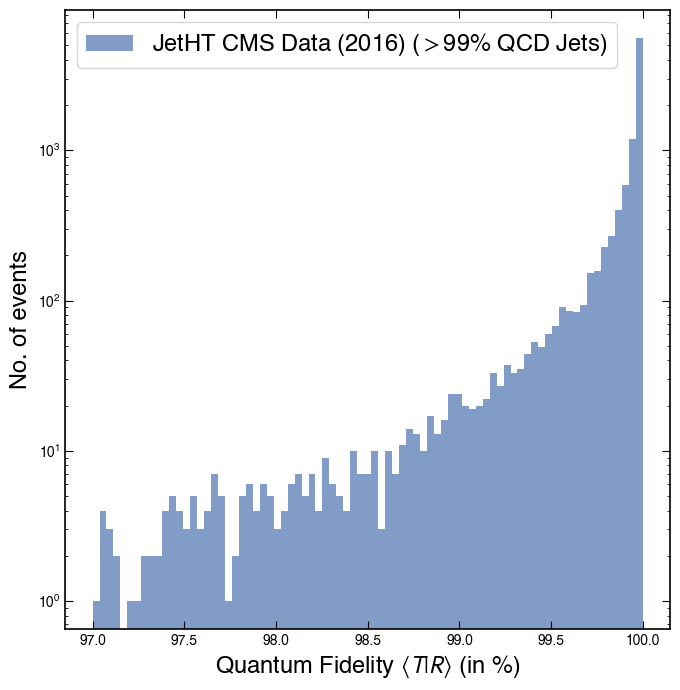

In [ ]:

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "mathtext.fontset": "stixsans",
    "axes.linewidth": 1.2,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    "xtick.top": True,
    "ytick.right": True,
})



bins = np.linspace(97, 100, 80)
plt.figure(figsize=(7, 7))
plt.hist(event_fidelities, bins=bins, histtype='stepfilled',
         color='#4C72B0', alpha=0.7, label=r'JetHT CMS Data (2016) ($>$99% QCD Jets)')
plt.yscale('log')
plt.xlabel(r'Quantum Fidelity $\langle T  | R \rangle$ (in %)', fontsize=17)
plt.ylabel(r'No. of events', fontsize=17)
plt.legend(loc='upper left', fontsize=17)
plt.tight_layout()
plt.show()

In [212]:
import matplotlib
print(matplotlib.rcParams["font.sans-serif"])

['Helvetica']


#  Inference and fidelity evaluation

This code performs **inference of the trained qutrit Quantum Autoencoder (QAE)** on multiple jet datasets and evaluates per-event quantum fidelities:

- **Datasets Tested:**  
  - Background jets (`X_inf`)  
  - Signal jets (`H→bb`, `t→bqq`, `W→qq`)

- **Fidelity Computation:**  
  For each jet, computes the **fidelity** using the QAE cost function and stores it per event (scaled to percentages).

- **Labeling:**  
  Assigns binary labels (`0` for background, `1` for signal) for later analysis.

- **Output:**  
  Prints completion messages for each dataset and measures the elapsed time for validation and signal inference.



In [235]:
from sklearn.metrics import roc_auc_score

event_fidelities_back = []
event_fidelities_HToBB = []
event_fidelities_WToQQ = []
event_fidelities_TTBar = []
fidelidades = []
etiquetas = []

inicio = time.time()
for jet in X_inf:
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity_qutrit(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_back.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(0)

end = time.time()
print("Finished validation test")
tiempo_test = (end - inicio)/ 60
print("Time elapsed: ", tiempo_test)

inicio = time.time()
for jet in datos_HToBB:
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity_qutrit(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_HToBB.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(1)

print("Finished test with HToBB")

for jet in datos_TTBar:
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity_qutrit(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_TTBar.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(1)

print("Finished test with TTBar")

for jet in datos_WToqq:
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity_qutrit(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_WToQQ.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(1)

print("Finished test with WToqq")
end = time.time()
tiempo_inf = (end - inicio)/ 60

Finished validation test
Time elapsed:  1.0014145692189536
Finished test with HToBB
Finished test with TTBar
Finished test with WToqq


# Fidelity distribution plot for QAE

This code generates a **histogram of quantum fidelities** for different jet datasets after QAE inference:

- **Datasets Visualized:**  
  - Background jets (`q/g jets`)  
  - Signal jets (`H→bb`, `t→bqq`, `W→qq`)

- **Plot Features:**  
  - Background filled in blue with transparency  
  - Signal jets shown as colored step lines with distinct colors  
  - Y-axis in logarithmic scale to highlight event distribution  
  - X-axis shows quantum fidelity percentages



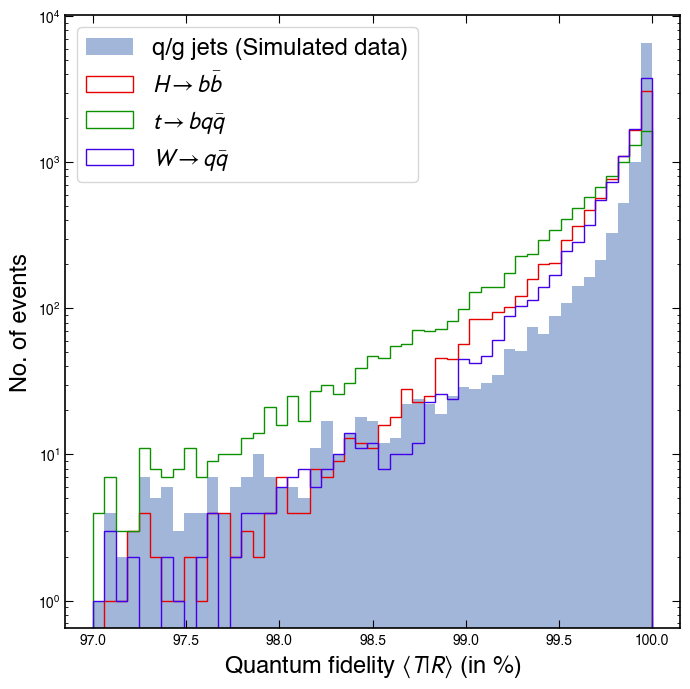

In [236]:
plt.figure(figsize=(7, 7))

# Defining bins (from 97 to 100, as in the reference)
bins = np.linspace(97, 100, 50)

# Background: blue fill
plt.hist(event_fidelities_back, 
         bins=bins, 
         histtype='stepfilled', 
         color="#7998CAB6", 
         alpha=0.7, 
         label=r'q/g jets (Simulated data)')

#  H → bb : 
plt.hist(event_fidelities_HToBB, 
         bins=bins, 
         histtype='step', 
         color="#E60000", 
         linewidth=1, 
         linestyle='-', 
         label=r'$H \rightarrow b\bar{b}$')

# t → bqq :
plt.hist(event_fidelities_TTBar, 
         bins=bins, 
         histtype='step', 
         color='#0D9101', 
         linewidth=1, 
         linestyle='-', 
         label=r'$t \rightarrow bq\bar{q}$')

#  W → qq : 
plt.hist(event_fidelities_WToQQ, 
         bins=bins, 
         histtype='step', 
         color="#4200EA", 
         linewidth=1, 
         linestyle='-', 
         label=r'$W \rightarrow q\bar{q}$')


plt.yscale('log')
plt.xlabel(r'Quantum fidelity $\langle T|R \rangle$ (in %)', fontsize=17)
plt.ylabel(r'No. of events', fontsize=17)
#plt.title(r'QAE trained on JetHT CMS Data (2016)', fontsize=12, pad=5)
plt.legend(loc='upper left', fontsize=17)
plt.tight_layout()
#plt.savefig("test_rots2.png", dpi=300, bbox_inches='tight')
plt.show()

# **ROC Curve and AUC Evaluation for Qutrit QAE**

This code evaluates the **anomaly detection performance of the Qutrit Quantum Autoencoder** using quantum fidelities:

- **Anomaly Scores:** Computed as `1 - fidelity` for background and signal jets.  
- **AUC Calculation:** Uses `roc_auc_score` to quantify discrimination between QCD background and signal jets (`H→bb`, `t→bqq`, `W→qq`).  
- **ROC Curves:**  
  - Plots True Positive Rate vs. False Positive Rate for each signal type.  
  - Uses different colors and line styles for visual distinction.  
  - Includes a diagonal random line (AUC = 0.5) as reference.  


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# --- Anomaly scores (1 - Fidelity) ---
anomaly_scores_back = 1 - np.array(event_fidelities_back)
anomaly_scores_HToBB = 1 - np.array(event_fidelities_HToBB)
anomaly_scores_TTBar = 1 - np.array(event_fidelities_TTBar)
anomaly_scores_WToQQ = 1 - np.array(event_fidelities_WToQQ)

# --- Calcular AUC ---
auc_HToBB = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_HToBB)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_HToBB])
)

auc_TTBar = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_TTBar)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_TTBar])
)

auc_WToQQ = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_WToQQ)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_WToQQ])
)

print(f"AUC (QCD vs H→bb): {auc_HToBB:.4f}")
print(f"AUC (QCD vs t→bqq): {auc_TTBar:.4f}")
print(f"AUC (QCD vs W→qq): {auc_WToQQ:.4f}")

# --- Graficar curvas ROC ---
plt.figure(figsize=(7, 7))

# H→bb
fpr_HToBB, tpr_HToBB, _ = roc_curve(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_HToBB)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_HToBB])
)
plt.plot(fpr_HToBB, tpr_HToBB, color='firebrick', linewidth=1,
         label=rf'$H \rightarrow b\bar{{b}}$ (AUC = {auc_HToBB:.3f})')

# t→bqq
fpr_TTBar, tpr_TTBar, _ = roc_curve(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_TTBar)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_TTBar])
)
plt.plot(fpr_TTBar, tpr_TTBar, color='forestgreen', linewidth=1, linestyle=':',
         label=rf'$t \rightarrow bq\bar{{q}}$ (AUC = {auc_TTBar:.3f})')

# W→qq
fpr_WToQQ, tpr_WToQQ, _ = roc_curve(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_WToQQ)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_WToQQ])
)
plt.plot(fpr_WToQQ, tpr_WToQQ, color='darkorange', linewidth=1, linestyle='--',
         label=rf'$W \rightarrow q\bar{{q}}$ (AUC = {auc_WToQQ:.3f})')

# Línea aleatoria (AUC = 0.5)
plt.plot([0, 1], [0, 1], 'k--', label=r'AUC = 0.5 (Random)')

# --- Personalización ejes y leyenda ---
plt.xlabel(r'False Positive Rate (FPR)', fontsize=12)
plt.ylabel(r'True Positive Rate (TPR)', fontsize=12)
#plt.title(r'ROC Curve ', fontsize=12, pad=5)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)

# Ajuste márgenes y guardado
plt.tight_layout()
plt.savefig("metricas_rots2.png", dpi=300, bbox_inches='tight')
plt.show()
